### Importing Dependences

In [3]:
import numpy as np
import pandas as pd

import os
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import warnings

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc( 
    "axes",
    labelweight = "bold",
    labelsize = "large",
    titleweight = "bold",
    titlesize = 14,
    titlepad = 10
)

# Mute warnings
warnings.filterwarnings('ignore')

/tmp/ipykernel_270417/412837057.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [4]:
# importing data for test and train purpose
train = pd.read_csv("/home/yash/project/Feynn_Labs/Project2 /Online-Vehicle-Booking-Market/Dataset/sigma_cabs.csv")
test = pd.read_csv("/home/yash/project/Feynn_Labs/Project2 /Online-Vehicle-Booking-Market/Dataset/test.csv")

<AxesSubplot: >

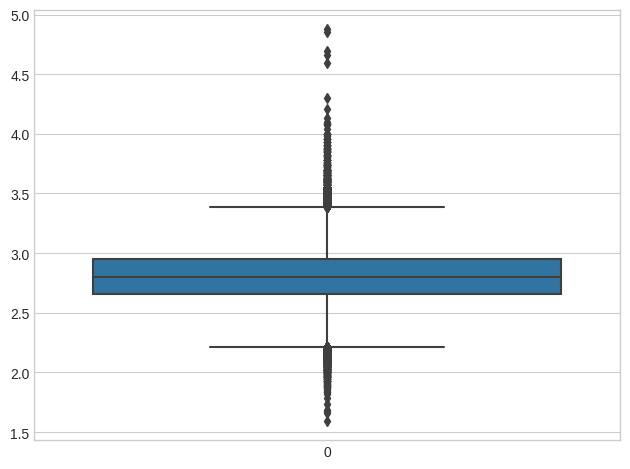

In [7]:
# data visualization for finding if data is skewed or uniform. Boxplot and density distribution plot tell how 
# data is distributed over the given range

sns.boxplot(train.Life_Style_Index)

<AxesSubplot: xlabel='Life_Style_Index', ylabel='Density'>

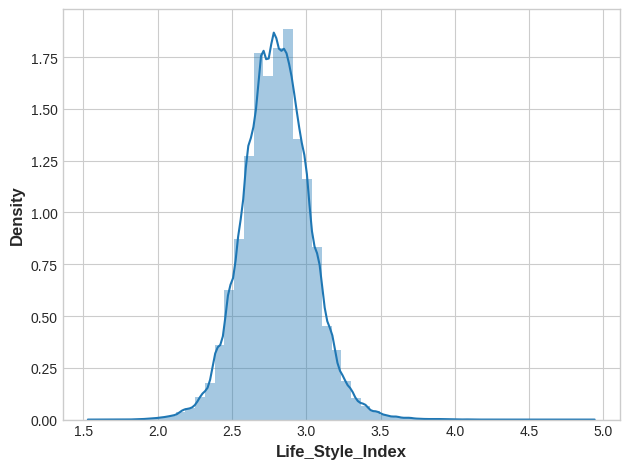

In [8]:
sns.distplot(train.Life_Style_Index)

<AxesSubplot: >

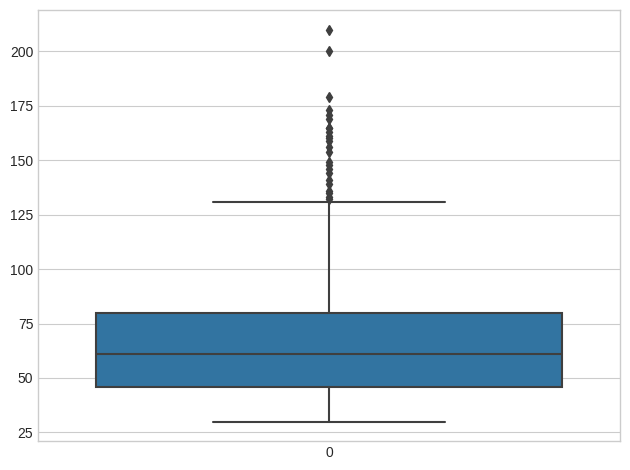

In [9]:
sns.boxplot(train.Var1)

<AxesSubplot: xlabel='Var1', ylabel='Density'>

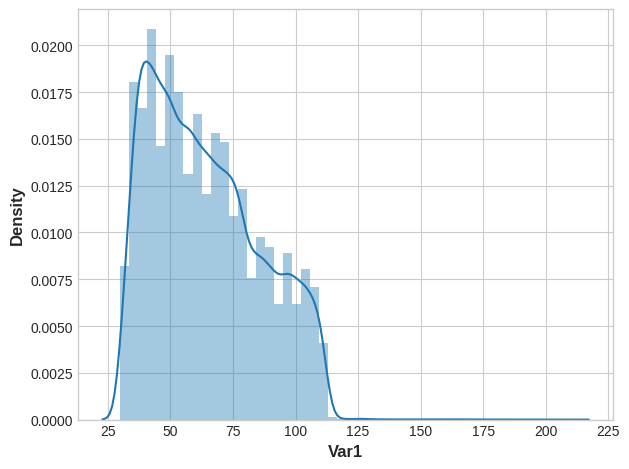

In [10]:
sns.distplot(train.Var1)

In [12]:
# imputing data with median values of numerical data of Var1 and Life_style_index using fillna function and 
# data of float type.

pd.options.display.max_rows = 999
var = train.Var1.median()
train["Var1"].fillna(var, inplace=True)
var = test.Var1.median()
test["Var1"].fillna(var, inplace=True)
var2 = train.Life_Style_Index.median()
train["Life_Style_Index"].fillna(var2, inplace=True)
var2 = test.Life_Style_Index.median()
test["Life_Style_Index"].fillna(var2, inplace=True)

In [13]:
# customer since months is a discrete features and classification variable. hence used mode strategy with it.
# it has lesser missing values so mode strategy would not lead to bad predictions.
from collections import Counter
n_num = train.Customer_Since_Months
n = len(n_num)

data = Counter(n_num)
get_mode  = dict(data)
mode = [k for k, v in get_mode.items() if v == max(list(data.values()))]

if len(mode) == n:
    get_mode = "No mode found"
else:
    get_mode = "Mode is / are:" + ', '.join(map(str, mode))

print(get_mode)

Mode is / are:10.0


In [15]:
# same finding mode method for test data
from collections import Counter
n_num = test.Customer_Since_Months
n = len(n_num)

data = Counter(n_num)
get_mode = dict(data)
mode = [k for k, v in get_mode.items() if v == max(list(data.values()))]

if len(mode) == n:
    get_mode = "No mode found"

else:
    get_mode = "Mode is / are: " + ', '.join(map(str, mode))

print(get_mode)

Mode is / are: 10.0


In [16]:
# filling the column with its mode value 
train["Confidence_Life_Style_Index"].fillna("B", inplace=True)
test["Confidence_Life_Style_Index"].fillna("B", inplace=True)
train.head(20)

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
0,T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
1,T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
2,T0005689464,41.58,NaN,10.0,2.79805,B,E,3.50125,2,61.0,56,77,Male,2
3,T0005689465,61.56,C,10.0,2.79805,B,A,3.45375,0,61.0,52,74,Male,3
4,T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2
5,T0005689469,19.06,E,10.0,2.79805,B,A,2.59750,1,72.0,63,91,Male,3
6,T0005689470,29.72,E,10.0,2.83958,C,B,2.97500,1,83.0,50,75,Male,2
7,T0005689472,18.44,B,2.0,2.81871,B,A,3.58250,0,103.0,46,63,Male,2
8,T0005689473,106.80,C,3.0,2.79805,B,A,3.14625,0,61.0,58,92,Male,2
9,T0005689474,107.19,D,5.0,3.04467,B,A,2.44375,1,61.0,58,83,Male,3


In [ ]:
# in type of cab I tried a different imputation technique keeping none as saperate category
train["Type_of_Cab"].fillna("none", inplace=True)
test["Type_of_Cab"]